In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from odtlearn.flow_oct import FlowOCT, BendersOCT
from odtlearn.utils.binarize import Binarizer

# `FlowOCT` Examples

## Example 0: Binarization

The following example shows how to binarize a dataset with categorical, integer, and continuous features using the built-in `Binarizer` class. This class follows the scikit-learn fit-transform paradigm, making it easy to integrate into your preprocessing pipeline.


In [2]:
number_of_child_list = [1, 2, 4, 3, 1, 2, 4, 3, 2, 1]
age_list = [10, 20, 40, 30, 10, 20, 40, 30, 20, 10]
race_list = [
    "Black",
    "White",
    "Hispanic",
    "Black",
    "White",
    "Black",
    "White",
    "Hispanic",
    "Black",
    "White",
]
sex_list = ["M", "F", "M", "M", "F", "M", "F", "M", "M", "F"]
income_list = [50000, 75000, 100000, 60000, 80000, 55000, 90000, 70000, 85000, 65000]

df = pd.DataFrame(
    list(zip(sex_list, race_list, number_of_child_list, age_list, income_list)),
    columns=["sex", "race", "num_child", "age", "income"],
)

print(df)

  sex      race  num_child  age  income
0   M     Black          1   10   50000
1   F     White          2   20   75000
2   M  Hispanic          4   40  100000
3   M     Black          3   30   60000
4   F     White          1   10   80000
5   M     Black          2   20   55000
6   F     White          4   40   90000
7   M  Hispanic          3   30   70000
8   M     Black          2   20   85000
9   F     White          1   10   65000


In [3]:
binarizer = Binarizer(
    categorical_cols=["sex", "race"],
    integer_cols=["num_child", "age"],
    real_cols=["income"],
    n_bins=5  # Number of bins for continuous features
)

# Fit and transform the data
df_enc = binarizer.fit_transform(df)

print(df_enc)

   sex_M  race_Black  race_Hispanic  race_White  num_child_1  num_child_2  \
0    1.0         1.0            0.0         0.0          1.0          1.0   
1    0.0         0.0            0.0         1.0          0.0          1.0   
2    1.0         0.0            1.0         0.0          0.0          0.0   
3    1.0         1.0            0.0         0.0          0.0          0.0   
4    0.0         0.0            0.0         1.0          1.0          1.0   
5    1.0         1.0            0.0         0.0          0.0          1.0   
6    0.0         0.0            0.0         1.0          0.0          0.0   
7    1.0         0.0            1.0         0.0          0.0          0.0   
8    1.0         1.0            0.0         0.0          0.0          1.0   
9    0.0         0.0            0.0         1.0          1.0          1.0   

   num_child_3  num_child_4  age_10  age_20  age_30  age_40  income_0  \
0          1.0          1.0     1.0     1.0     1.0     1.0       1.0   
1     

The `Binarizer` class follows the scikit-learn fit-transform paradigm:

We initialize the `Binarizer` with our desired parameters, specifying which columns are categorical, integer, and real-valued.
We call the fit_transform method, which first fits the binarizer to our data (learning the necessary encoding schemes) and then transforms the data using those learned encodings.

The resulting `df_enc` DataFrame contains the binarized version of our original data:

Categorical columns (sex, race) are one-hot encoded.
Integer columns (num_child, age) are binary encoded, where each column represents "greater than or equal to" a certain value.
The continuous column (income) is first discretized into 5 bins, then binary encoded similar to the integer columns.

In [4]:
print(df_enc.columns)

Index(['sex_M', 'race_Black', 'race_Hispanic', 'race_White', 'num_child_1',
       'num_child_2', 'num_child_3', 'num_child_4', 'age_10', 'age_20',
       'age_30', 'age_40', 'income_0', 'income_1', 'income_2', 'income_3',
       'income_4'],
      dtype='object')


This binarized data is now ready to be used with any of the models in ODTlearn, which require binary input features.
If you need to transform new data using the same encoding scheme, you can use the transform method of the fitted binarizer:

In [5]:
new_data = pd.DataFrame({
    "sex": ["F", "M"],
    "race": ["Hispanic", "White"],
    "num_child": [2, 3],
    "age": [20, 30],
    "income": [70000, 80000]
})

new_data_enc = binarizer.transform(new_data)
print(new_data_enc)

   sex_M  race_Black  race_Hispanic  race_White  num_child_1  num_child_2  \
0    0.0         0.0            1.0         0.0          0.0          1.0   
1    1.0         0.0            0.0         1.0          0.0          0.0   

   num_child_3  num_child_4  age_10  age_20  age_30  age_40  income_0  \
0          1.0          1.0     0.0     1.0     1.0     1.0         0   
1          1.0          1.0     0.0     0.0     1.0     1.0         0   

   income_1  income_2  income_3  income_4  
0         0       1.0       1.0         0  
1         0       0.0       1.0         0  


Note that for categorical features, if the new data contains categories not seen during fitting, the transform method will raise an error. In such cases, you might need to refit the binarizer on a dataset that includes all possible categories.

## Example 1: Varying `depth` and `_lambda`
In this part, we study a simple example and investigate different parameter combinations to provide intuition on how they affect the structure of the tree.

First we generate the data for our example. The diagram within the code block shows the training dataset. Our dataset has two binary features (X1 and X2) and two class labels (+1 and -1).

In [6]:
from odtlearn.datasets import flow_oct_example

"""
    X2
    |               |
    |               |
    1    + +        |    -
    |               |   
    |---------------|-------------
    |               |
    0    - - - -    |    + + +
    |    - - -      |
    |______0________|_______1_______X1
"""


X, y = flow_oct_example()

### Tree with `depth = 1`

In the following, we fit a classification tree of depth 1, i.e., a tree with a single branching node and two leaf nodes.

In [7]:
stcl = FlowOCT(depth=1, solver="gurobi", time_limit=100)
stcl.store_search_progress_log = True
stcl.fit(X, y)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-28
Set parameter TimeLimit to value 100
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 110 rows, 89 columns and 250 nonzeros
Model fingerprint: 0x5e9209d1
Variable types: 84 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 102 rows and 82 columns
Presolve time: 0.00s
Presolved: 8 rows, 7 columns, 16 nonzeros
Variable types: 6 continuous, 1 integer (1 binary)
Found heuristic solution: objective 9.0000000

Root relaxation: objective 1.000000e+01,

FlowOCT(solver=gurobi,depth=1,time_limit=100,num_threads=None,verbose=False)

In [8]:
predictions = stcl.predict(X)
print(f'Optimality gap is {stcl.optim_gap}')
print(f"In-sample accuracy is {np.sum(predictions==y)/y.shape[0]}")

Optimality gap is 0.0
In-sample accuracy is 0.7692307692307693


Users can access statistics from the optimization run such as optimality gap, number of nodes, number of constraints, etc. Directly as properties of the initialized class or through the `_solver` object. For example, one can access the optimality gap and the number of solutions after fitting the optimal decision tree through the `optim_gap` and `num_solutions` properties.

In [9]:
print(f'Optimality gap is {stcl.optim_gap}')
print(f'Number of solutions {stcl.num_solutions}')

Optimality gap is 0.0
Number of solutions 2


As we can see above, we find the optimal tree and the in-sample accuracy is 76%.

ODTlearn provides two different ways of visualizing the structure of the tree. The first method prints the structure of the tree in the console:

In [10]:
stcl.print_tree()

#########node  1
branch on X_0
#########node  2
leaf 0
#########node  3
leaf 1


The second method plots the structure of the tree using `matplotlib`:

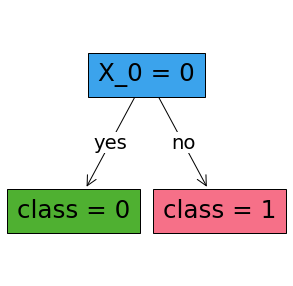

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
stcl.plot_tree(ax=ax)
plt.show()

We also provide a simple function allowing users to plot the search progress log over time. Note that you must set the attribute `store_search_progress_log` to `True` before calling the `fit` method to ensure that the bound information is stored. 

In [12]:
stcl_progress_log = FlowOCT(depth=1, solver="gurobi", time_limit=100)
stcl_progress_log.store_search_progress_log = True
stcl_progress_log.fit(X, y)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-28
Set parameter TimeLimit to value 100
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 110 rows, 89 columns and 250 nonzeros
Model fingerprint: 0x5e9209d1
Variable types: 84 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 102 rows and 82 columns
Presolve time: 0.00s
Presolved: 8 rows, 7 columns, 16 nonzeros
Variable types: 6 continuous, 1 integer (1 binary)
Found heuristic solution: objective 9.0000000

Root relaxation: objective 1.000000e+01,

FlowOCT(solver=gurobi,depth=1,time_limit=100,num_threads=None,verbose=False)

<AxesSubplot:title={'center':'Search Progress'}, xlabel='Time (s)', ylabel='Objective Bound'>

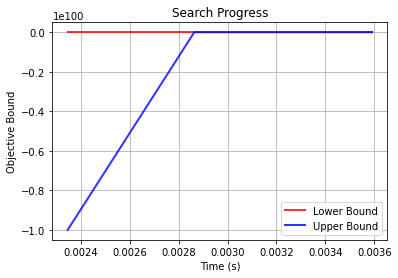

In [13]:
stcl.plot_search_progress()

### Tree with `depth = 2`

Now we increase the depth of the tree to achieve higher accuracy.

In [14]:
stcl = FlowOCT(depth=2, solver="gurobi")
stcl.fit(X, y)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-28
Set parameter TimeLimit to value 60
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 274 rows, 209 columns and 642 nonzeros
Model fingerprint: 0x51470803
Variable types: 196 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 250 rows and 187 columns
Presolve time: 0.00s
Presolved: 24 rows, 22 columns, 76 nonzeros
Found heuristic solution: objective 8.0000000
Variable types: 16 continuous, 6 intege

FlowOCT(solver=gurobi,depth=2,time_limit=60,num_threads=None,verbose=False)

In [15]:
predictions = stcl.predict(X)
print(f"In-sample accuracy is {np.sum(predictions==y)/y.shape[0]}")

In-sample accuracy is 1.0


As we can see, with depth 2, we can achieve 100% in-sample accuracy.

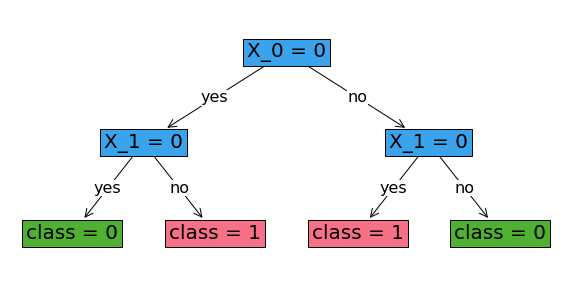

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
stcl.plot_tree(ax=ax, fontsize=20)
plt.show()

### Tree with `depth=2` and Positive `_lambda`

As we saw in the above example, with depth 2, we can fully classify the training data. However if we add a regularization term with a high enough value of `_lambda`, we can justify pruning one of the branching nodes to get a sparser tree. In the following, we observe that as we increase `_lambda` from 0 to 0.51, one of the branching nodes gets pruned and as a result, the in-sample accuracy drops to 92%.

In [17]:
stcl = FlowOCT(solver="gurobi", depth=2, _lambda=0.51)
stcl.fit(X, y)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-28
Set parameter TimeLimit to value 60
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 274 rows, 209 columns and 642 nonzeros
Model fingerprint: 0x3e3f455b
Variable types: 196 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 250 rows and 187 columns
Presolve time: 0.00s
Presolved: 24 rows, 22 columns, 76 nonzeros
Found heuristic solution: objective 3.9200000
Variable types: 16 continuous, 6 intege

FlowOCT(solver=gurobi,depth=2,time_limit=60,num_threads=None,verbose=False)

In [18]:
predictions = stcl.predict(X)
print(f"In-sample accuracy is {np.sum(predictions==y)/y.shape[0]}")

In-sample accuracy is 0.9230769230769231


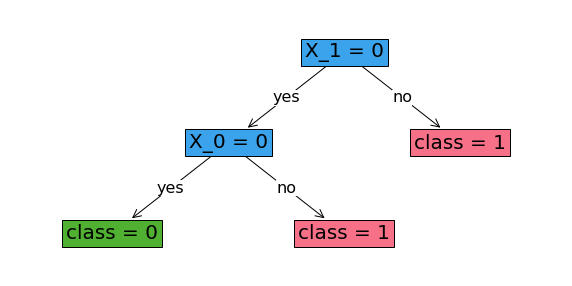

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
stcl.plot_tree(ax=ax, fontsize=20)
plt.show()

## Example 2: Different Objective Functions

In the following, we have a toy example with an imbalanced data, with the positive class being the minority class.

In [20]:
'''
    X2
    |               | 
    |               |
    1    + - -      |    -
    |               |   
    |---------------|--------------
    |               |
    0    - - - +    |    - - -
    |    - - - -    |
    |______0________|_______1_______X1
'''
X = np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],
              [1,0],[1,0],[1,0],
              [1,1],
              [0,1],[0,1],[0,1]])
y = np.array([0,0,0,0,0,0,0,1,
              0,0,0,
              0,
              1,0,0])

### Tree with classification accuracy objective

In [21]:
stcl_acc = FlowOCT(solver="gurobi", depth=2, obj_mode="acc")
stcl_acc.fit(X, y)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-28
Set parameter TimeLimit to value 60
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 314 rows, 237 columns and 734 nonzeros
Model fingerprint: 0xa5b9a46b
Variable types: 224 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 269 rows and 203 columns
Presolve time: 0.00s
Presolved: 45 rows, 34 columns, 134 nonzeros
Found heuristic solution: objective 13.0000000
Variable types: 27 continuous, 7 inte

FlowOCT(solver=gurobi,depth=2,time_limit=60,num_threads=None,verbose=False)

In [22]:
predictions = stcl_acc.predict(X)
print(f"In-sample accuracy is {np.sum(predictions==y)/y.shape[0]}")

In-sample accuracy is 0.8666666666666667


In [23]:
stcl_acc.print_tree()

#########node  1
leaf 0
#########node  2
pruned
#########node  3
pruned
#########node  4
pruned
#########node  5
pruned
#########node  6
pruned
#########node  7
pruned


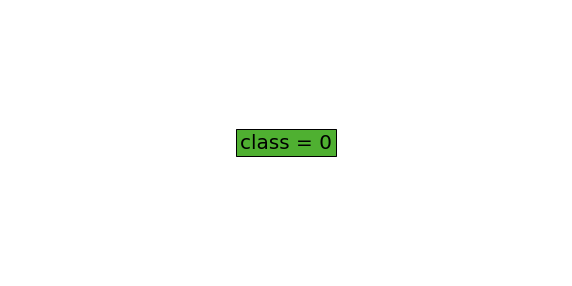

In [24]:
fig, ax = plt.subplots(figsize=(10, 5)) 
stcl_acc.plot_tree(ax=ax, fontsize=20)
plt.show()

### Tree with Balanced Classification Accuracy Objective

In [25]:
stcl_balance = FlowOCT(
    solver="gurobi",
    depth=2,
    obj_mode="balance",
    _lambda=0,
    verbose=False,
)
stcl_balance.fit(X, y)
predictions = stcl_balance.predict(X)
print(f"In-sample accuracy is {np.sum(predictions==y)/y.shape[0]}")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-28
Set parameter TimeLimit to value 60
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 314 rows, 237 columns and 734 nonzeros
Model fingerprint: 0x3bc6df12
Variable types: 224 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 269 rows and 203 columns
Presolve time: 0.01s
Presolved: 45 rows, 34 columns, 134 nonzeros
Found heuristic solution: objective 0.5000000
Variable types: 27 continuous, 7 integ

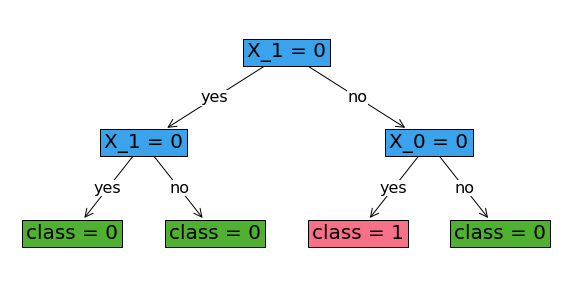

In [26]:
fig, ax = plt.subplots(figsize=(10, 5)) 
stcl_balance.plot_tree(ax=ax, fontsize=20)
plt.show()

As we can see, when we maximize accuracy, i.e., when `obj_mode = 'acc'`, the optimal tree is just a single node without branching, predicting the majority class for the whole dataset. But when we change the objective mode to balanced accuracy, we account for the minority class by sacrificing the overal accuracy.

## Example 3: UCI Data Example

In this section, we fit a tree of depth 3 on a real world dataset called the [`balance` dataset](https://archive.ics.uci.edu/ml/datasets/Balance+Scale) from the UCI Machine Learning repository. 

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from odtlearn.datasets import balance_scale_data

In [28]:
# read data
data = balance_scale_data()
print(f"shape{data.shape}")
data.columns

shape(625, 21)


Index(['V2.1', 'V2.2', 'V2.3', 'V2.4', 'V2.5', 'V3.1', 'V3.2', 'V3.3', 'V3.4',
       'V3.5', 'V4.1', 'V4.2', 'V4.3', 'V4.4', 'V4.5', 'V5.1', 'V5.2', 'V5.3',
       'V5.4', 'V5.5', 'target'],
      dtype='object')

In [29]:
y = data.pop("target")

X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.33, random_state=42
)

In [30]:
stcl = BendersOCT(solver="gurobi", depth=3, time_limit=200, obj_mode="acc", verbose=True)

stcl.fit(X_train, y_train)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-28
Set parameter TimeLimit to value 200
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 30 rows, 618 columns and 249 nonzeros
Model fingerprint: 0xaeff5467
Variable types: 463 continuous, 155 integer (155 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 8 rows and 8 columns
Presolve time: 0.00s
Presolved: 22 rows, 610 columns, 233 nonzeros
Variable types: 463 continuous, 147 integer (147 binary)
Root relaxation presolved: 412 row

BendersOCT(solver=gurobi,depth=3,time_limit=200,num_threads=None,verbose=True)

In [31]:
stcl.print_tree()

#########node  1
branch on V3.2
#########node  2
branch on V3.1
#########node  3
branch on V5.1
#########node  4
branch on V2.1
#########node  5
branch on V5.1
#########node  6
branch on V4.1
#########node  7
branch on V2.1
#########node  8
leaf 2
#########node  9
leaf 3
#########node  10
leaf 3
#########node  11
leaf 2
#########node  12
leaf 3
#########node  13
leaf 2
#########node  14
leaf 2
#########node  15
leaf 3


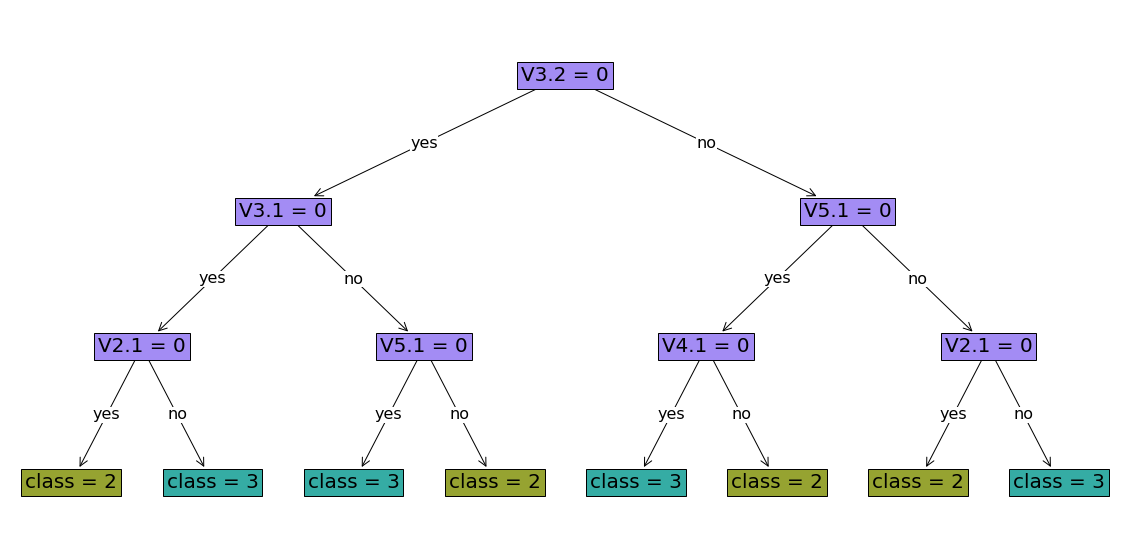

In [32]:
fig, ax = plt.subplots(figsize=(20, 10))
stcl.plot_tree(ax=ax, fontsize=20, color_dict={"node": None, "leaves": []})
plt.show()

In [33]:
test_pred = stcl.predict(X_test)
print('The out-of-sample accuracy is {}'.format(np.sum(test_pred==y_test)/y_test.shape[0]))

The out-of-sample accuracy is 0.6859903381642513


## Example 4: User-defined Weights

In this example, we'll demonstrate how to use user-defined weights with FlowOCT and BendersOCT. We'll use a small binary classification dataset and show how user-defined weights can affect the learned tree.

First, let's create our small binary classification dataset:

In [34]:
np.random.seed(42)
X = np.random.randint(0, 2, size=(20, 5))
y = np.random.randint(0, 2, size=20)

print("Dataset shape:", X.shape)
print("Class distribution:", np.bincount(y))

Dataset shape: (20, 5)
Class distribution: [ 6 14]


Now, let's create weights that heavily favor class 1:

In [35]:
weights = np.ones_like(y)
weights[y == 1] = 10

print("Weight distribution:")
print("Class 0:", weights[y == 0].mean())
print("Class 1:", weights[y == 1].mean())

Weight distribution:
Class 0: 1.0
Class 1: 10.0


### FlowOCT with User-defined Weights
Let's fit a FlowOCT model with user-defined weights and compare it to a model without the accuracy objective:

In [36]:
# FlowOCT without custom weights
flow_oct_default = FlowOCT(solver="gurobi", obj_mode="acc", depth=2, time_limit=10)
flow_oct_default.fit(X, y)

# FlowOCT with custom weights
flow_oct_custom = FlowOCT(solver="gurobi", obj_mode="weighted", depth=2, time_limit=10)
flow_oct_custom.fit(X, y, weights=weights)

print("Default FlowOCT predictions:", flow_oct_default.predict(X))
print("User-defined weights FlowOCT predictions:", flow_oct_custom.predict(X))

print("Default FlowOCT accuracy:", (flow_oct_default.predict(X) == y).mean())
print("User-defined weights FlowOCT accuracy:", (flow_oct_custom.predict(X) == y).mean())
print("User-defined weights FlowOCT weighted accuracy:", np.average(flow_oct_custom.predict(X) == y, weights=weights))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-28
Set parameter TimeLimit to value 10
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 414 rows, 316 columns and 1153 nonzeros
Model fingerprint: 0x1ad65f5a
Variable types: 294 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 205 rows and 186 columns
Presolve time: 0.00s
Presolved: 209 rows, 130 columns, 660 nonzeros
Found heuristic solution: objective 14.0000000
Variable types: 112 continuous, 18

Let's visualize both trees:

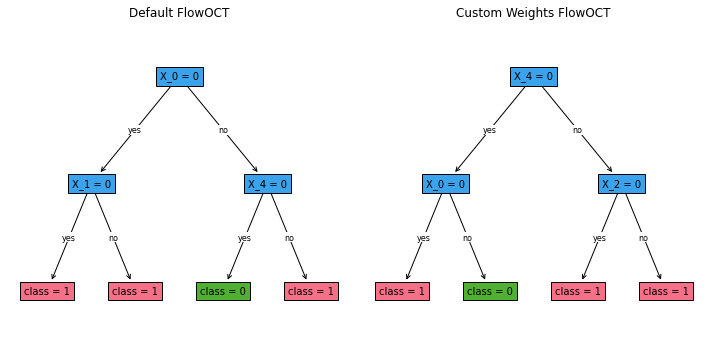

In [37]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

flow_oct_default.plot_tree(ax=ax1, fontsize=10)
ax1.set_title("Default FlowOCT")

flow_oct_custom.plot_tree(ax=ax2, fontsize=10)
ax2.set_title("User-defined Weights FlowOCT")

plt.tight_layout()
plt.show()

### BendersOCT with User-defined Weights
Now let's do the same with BendersOCT:

In [38]:
# BendersOCT without custom weights
benders_oct_default = BendersOCT(solver="gurobi", obj_mode="acc", depth=2, time_limit=10)
benders_oct_default.fit(X, y)

# BendersOCT with custom weights
benders_oct_custom = BendersOCT(solver="gurobi", obj_mode="weighted", depth=2, time_limit=10, verbose=False)
benders_oct_custom.fit(X, y, weights=weights)

print("Default BendersOCT predictions:", benders_oct_default.predict(X))
print("User-defined weights BendersOCT predictions:", benders_oct_custom.predict(X))

print("Default BendersOCT accuracy:", (benders_oct_default.predict(X) == y).mean())
print("User-defined weights BendersOCT accuracy:", (benders_oct_custom.predict(X) == y).mean())
print("User-defined weights BendersOCT weighted accuracy:", np.average(benders_oct_custom.predict(X) == y, weights=weights))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-28
Set parameter TimeLimit to value 10
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14 rows, 56 columns and 53 nonzeros
Model fingerprint: 0x28902962
Variable types: 34 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 4 rows and 4 columns
Presolve time: 0.00s
Presolved: 10 rows, 52 columns, 45 nonzeros
Variable types: 34 continuous, 18 integer (18 binary)
Root relaxation presolved: 22 rows, 50 column

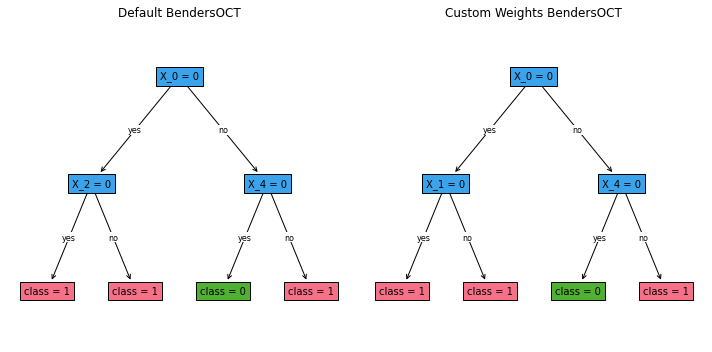

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

benders_oct_default.plot_tree(ax=ax1, fontsize=10)
ax1.set_title("Default BendersOCT")

benders_oct_custom.plot_tree(ax=ax2, fontsize=10)
ax2.set_title("User-defined Weights BendersOCT")

plt.tight_layout()
plt.show()

In this example, we've demonstrated how to use user-defined weights with both FlowOCT and BendersOCT. By setting `obj_mode="weighted"` and providing weights during the `fit` method call, we can influence the importance of different samples in the training process.
The user-defined weights in this example heavily favor class 1, which may result in trees that are more likely to predict class 1, potentially at the cost of overall accuracy. However, this can be useful in scenarios where misclassifying one class is more costly than misclassifying the other, or when dealing with imbalanced datasets.
Note that the actual results may vary due to the random nature of the dataset and the optimization process. You may want to run the code multiple times or with different random seeds to get a better understanding of the effects of user-defined weights.

## References
* Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.
* Aghaei, S., Gómez, A., & Vayanos, P. (2021). Strong optimal classification trees. arXiv preprint arXiv:2103.15965. https://arxiv.org/abs/2103.15965.